# Identifying and Explaining Crime Hotspots in London

In [4]:
# Data reading and processing

In [7]:
# load all the packages first
import os
import pandas as pd
import geopandas as gpd
import requests
import zipfile
from pathlib import Path
import numpy as np
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from kneed import KneeLocator
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [2]:
# read in LSOA crime data
df_recent = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(most%20recent%2024%20months).csv")
df_historical = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(Historical).csv")

# read in 2021 census data
df_residents = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/population.csv")
df_qualification = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/highest_level_of_qualification.csv")
df_language = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/household_language.csv")
df_economic_active = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/economic_active_status.csv")
df_car = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/car_or_van_availability.csv")
df_bedrooms = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/occupancy_rating_for_bedrooms.csv")
df_health = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/general_health.csv")
df_disability = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/disability.csv")

# read in PTAI data
df_PTAI = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/LSOA2011_AvPTAI2015.csv")

In [8]:
# download geo boundaries

# first download the zip file to the data folder, and then unzip it to data/LSOA_Boundaries_London/
# create a "data" folderÔºàif do not existÔºâ
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# download the zip file (if do not exist)
zip_filename = "LSOA_Boundaries_London.zip"
zip_path = os.path.join(data_dir, zip_filename)

if not os.path.exists(zip_path):
    url = "https://github.com/Weining5619/DSSS/raw/main/data/LSOA_Boundaries_London.zip"
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            f.write(response.content)
    else:
        raise Exception(f"Download failed. Status code: {response.status_code}")

# unzip the file (if do not exist)
extract_dir = os.path.join(data_dir, "LSOA_Boundaries_London")
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)


In [9]:
# read in the shapefiles
# (It is a bit complicated here because the LSOA boundaries I found are stored by borough)

shp_folder = "data/LSOA_Boundaries_London"

# find all .shp files
shp_files = [
    shp for shp in Path(shp_folder).rglob("*.shp")
    if not shp.name.startswith("._") # exclude cache files generated by macOS when unzipping (e.g. ._xxx.shp), as they will cause errors.
]

# read them all into a gdf
gdf_list = [gpd.read_file(shp) for shp in shp_files]
gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

In [10]:
# conver crime data to long table
# first replace spaces in column names with underscores

def clean_columns(df):
    '''
    Unify the format of column names
    '''
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    if "geography_code" in df.columns:
        df.rename(columns={"geography_code": "LSOA_Code"}, inplace=True)
    return df

df_recent = clean_columns(df_recent)

# find all the columns of months
date_cols_rec = [col for col in df_recent.columns if col.isdigit() and col < "202501"]

# conver to long table
df_recent_long = df_recent.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_rec,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_recent_new = gdf[["LSOA11CD"]].copy()
df_recent_new = df_recent_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_recent_new = df_recent_new.merge(df_recent_long, on="LSOA_Code", how="left")

In [11]:
# do similar processing on historical crime data
df_historical = clean_columns(df_historical)

# drop columns before the year 2021
date_cols_his = [col for col in df_historical.columns if col.isdigit() and col >= "202101"]
cols_to_keep = ["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"] + date_cols_his
df_historical = df_historical[cols_to_keep]

# conver to long table
df_historical_long = df_historical.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_his,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_historical_new = gdf[["LSOA11CD"]].copy()
df_historical_new = df_historical_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_historical_new = df_historical_new.merge(df_historical_long, on="LSOA_Code", how="left")

In [13]:
# combine crime data of recent 24 months and historical
df_crime = pd.concat([df_historical_new, df_recent_new], ignore_index=True)



In [16]:
# count the number of crimes by year
df_crime["Year"] = df_crime["YearMonth"].str[:4] # extract the year
annual_crime_count = df_crime.groupby(["LSOA_Code","Year", "Major_Category"])["CrimeCount"].sum().reset_index()


In [18]:
# handle column names 
df_residents = clean_columns(df_residents)
df_residents = df_residents.rename(columns={"LSOA_code": "LSOA_Code"})
df_population = df_residents[["LSOA_Code", "All_usual_residents"]].copy()

# merge population and crime count
crime_rate = annual_crime_count.merge(df_population, on="LSOA_Code", how="left")

# calculate the number of cases per 1000 population as the crime rate
crime_rate["Crime_Rate_per_1000"] = crime_rate["CrimeCount"] / crime_rate["All_usual_residents"] * 1000

df_all = crime_rate[["LSOA_Code", "Year", "Major_Category", "Crime_Rate_per_1000"]]

Âú®Êú¨Á†îÁ©∂‰∏≠ÔºåÊï∞ÊçÆÊ∂âÂèäÁöÑ LSOA Êï∞ÈáèÂ≠òÂú®‰∏ÄÂÆöÂ∑ÆÂºÇ„ÄÇÊ†πÊçÆ 2011 Âπ¥ÁöÑÂÆòÊñπËæπÁïåÊï∞ÊçÆÔºå‰º¶Êï¶ÂÖ±ÂàíÂàÜ‰∏∫ 4,835 ‰∏™ LSOA„ÄÇÁÑ∂ËÄåÔºå2021 Âπ¥‰∫∫Âè£ÊôÆÊü•ÔºàCensus 2021Ôºâ‰∏≠‰ªÖÂØπÂÖ∂‰∏≠ 4,659 ‰∏™ LSOA Êèê‰æõ‰∫ÜËØ¶ÁªÜÁöÑÁ§æ‰ºöÁªèÊµéÊï∞ÊçÆÔºåËøô‰∏ªË¶ÅÊòØÂõ†‰∏∫ÈÉ®ÂàÜÂå∫ÂüüÔºàÂ¶ÇÂÖ¨Âõ≠„ÄÅÂ∑•‰∏öÂå∫„ÄÅÊú∫Âú∫Á≠âÔºâÂ±û‰∫éÈùû‰ΩèÂÆÖÂå∫ÂüüÔºåÊó†Â∏∏‰Ωè‰∫∫Âè£ÔºåÂõ†Ê≠§Êú™Ë¢´Á∫≥ÂÖ•ÁªüËÆ°„ÄÇÂêåÊ†∑Âú∞ÔºåÂú®ÁäØÁΩ™Êï∞ÊçÆ‰∏≠Ôºå‰πüÂèØËÉΩÂ≠òÂú®ÈÉ®ÂàÜ LSOA Âõ†Êó†Êä•Ê°àËÆ∞ÂΩïËÄåÁº∫Â§±„ÄÇ

Èâ¥‰∫éÊú¨Á†îÁ©∂ÂÖ≥Ê≥®ÁöÑÊòØÁäØÁΩ™Áéá‰∏éÁ§æ‰ºöÁªèÊµéÂèòÈáè‰πãÈó¥ÁöÑÂÖ≥Á≥ªÔºåÂ∞ÜËøô‰∫õÊú™ÂèÇ‰∏éÁªüËÆ°ÊàñÊú™ÂèëÁîüÁäØÁΩ™ÁöÑÂå∫ÂüüËßÜ‰∏∫‚ÄúÁäØÁΩ™‰∏∫ 0‚Äù ÊòØÂêàÁêÜ‰∏îÂ∏∏ËßÅÁöÑÂ§ÑÁêÜÊñπÂºè„ÄÇËøôÊ†∑ÁöÑÁÆÄÂåñ‰∏ç‰ºöÂΩ±ÂìçÂØπÊï¥‰ΩìÊ®°ÂºèÁöÑÂàÜÊûêÔºåÂèçËÄåÊúâÂä©‰∫é‰øùÊåÅÊï∞ÊçÆÁöÑ‰∏ÄËá¥ÊÄß‰∏éÁ®≥ÂÆöÊÄß„ÄÇ

In [19]:
# process census data
df_qualification = clean_columns(df_qualification)
df_language = clean_columns(df_language)
df_economic_active = clean_columns(df_economic_active)
df_car = clean_columns(df_car)
df_bedrooms = clean_columns(df_bedrooms)
df_health = clean_columns(df_health)
df_disability = clean_columns(df_disability)
df_PTAI = clean_columns(df_PTAI)
df_PTAI = df_PTAI.rename(columns={"LSOA2011": "LSOA_Code"})

# drop all "date", "geography" columns to prevent duplicate columns which causes errors when merge
df_language.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_economic_active.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_car.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_bedrooms.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_health.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_disability.drop(columns=["date", "geography"], inplace=True, errors="ignore")

# merge all census as a combined dataframe
df_var = df_qualification.merge(df_language, on="LSOA_Code", how="left")
df_var = df_var.merge(df_economic_active, on="LSOA_Code", how="left")
df_var = df_var.merge(df_car, on="LSOA_Code", how="left")
df_var = df_var.merge(df_bedrooms, on="LSOA_Code", how="left")
df_var = df_var.merge(df_health, on="LSOA_Code", how="left")
df_var = df_var.merge(df_disability, on="LSOA_Code", how="left")
df_var = df_var.merge(df_PTAI, on="LSOA_Code", how="left")

# Keep only the data of London
London_LOSAs = gdf["LSOA11CD"].tolist()
df_var = df_var[df_var["LSOA_Code"].isin(London_LOSAs)].copy()

In [20]:
# process all the variables
# Low_Education_Rate = (No qualifications + Level1 + Level2) / All above 16
df_var["Low_Education_Rate"] = (
    df_var["Highest_level_of_qualification:_No_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_1_and_entry_level_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_2_qualifications"]
) / df_var["Highest_level_of_qualification:_Total:_All_usual_residents_aged_16_years_and_over"]

# Non_English_Household_Rate = (no English + no adults but children) / All
df_var["Non_English_Household_Rate"] = (
    df_var["Household_language_(English_and_Welsh):_No_people_in_household_have_English_in_England,_or_English_or_Welsh_in_Wales_as_a_main_language"] +
    df_var["Household_language_(English_and_Welsh):_No_adults_in_household,_but_at_least_one_person_aged_3_to_15_years,_has_English_in_England_or_English_or_Welsh_in_Wales_as_a_main_language"]
) / df_var["Household_language_(English_and_Welsh):_Total:_All_households"]

# Unemployed_Rate = unemployed (students + nonstudents) / All economically active
#   According to the standard definition of unemployment rate used by ONS and ILO, 
#   economically inactive people, such as students, retirees, and those taking care of families, are not included in the denominator.
df_var["Unemployed_Rate"] = (
    df_var["Economic_activity_status:_Economically_active_(excluding_full-time_students):_Unemployed"] +
    df_var["Economic_activity_status:_Economically_active_and_a_full-time_student:_Unemployed"]
) / (df_var["Economic_activity_status:_Total:_All_usual_residents_aged_16_years_and_over"]-
    df_var["Economic_activity_status:_Economically_inactive"])

# No_Car_Rate = No car / All
df_var["No_Car_Rate"] = df_var["Number_of_cars_or_vans:_No_cars_or_vans_in_household"] / df_var["Number_of_cars_or_vans:_Total:_All_households"]

# Overcrowding_Rate = lack of bedrooms / All
df_var["Overcrowding_Rate"] = (
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-1"] +
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-2_or_less"]
) / df_var["Occupancy_rating_for_bedrooms:_Total:_All_households"]

# Poor_Health_Rate = bad health + very bad / All
df_var["Poor_Health_Rate"] = (
    df_var["General_health:_Bad_health"] +
    df_var["General_health:_Very_bad_health"]
) / df_var["General_health:_Total:_All_usual_residents"]

# Disability_Rate = disabled / All
df_var["Disabled_Rate"] = df_var["Disability:_Disabled_under_the_Equality_Act"] / df_var["Disability:_Total:_All_usual_residents"]

# Long_Term_Sick_Rate = long-term sick / All
df_var["Long_Term_Sick_Rate"] = df_var["Disability:_Not_disabled_under_the_Equality_Act:_Has_long_term_physical_or_mental_health_condition_but_day-to-day_activities_are_not_limited"] / df_var["Disability:_Total:_All_usual_residents"]

# Public_Transport_Accessibility_Index
df_var["Public_Transport_Accessibility"] = df_var["AvPTAI2015"]

# merge the data obtained above into crime rate
col_vars = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "Public_Transport_Accessibility"
]
df_var_only = df_var[["LSOA_Code"] + col_vars]
df_all = df_all.merge(df_var_only, on=["LSOA_Code"], how="left")

ÁäØÁΩ™Ë°å‰∏∫ÁöÑ‰∫ßÁîüÂæÄÂæÄ‰∏éË∫´ÂøÉËÑÜÂº±Áä∂ÊÄÅÂØÜÂàáÁõ∏ÂÖ≥ÔºåËÄå‚ÄúÈùûÊÆãÁñæ‰ΩÜÊúâÈïøÊúüÁñæÁóÖ‚ÄùÊ≠£ÊòØËøô‰∏™Ê®°Á≥äËæπÁïå‰∏≠ÊúÄÂÆπÊòìË¢´ÂøΩËßÜÁöÑ‰∏ÄÁ±ª‰∫∫Áæ§„ÄÇÂæàÂ§öÁ†îÁ©∂Ë°®ÊòéÔºåÊÖ¢ÊÄßÁóÖÊàñÂøÉÁêÜÈóÆÈ¢òÊú™ÂøÖÈôêÂà∂Êó•Â∏∏Ê¥ªÂä®Ôºå‰ΩÜÁ°ÆÂÆûÈôç‰Ωé‰∫ÜÁ§æ‰ºöÈÄÇÂ∫îËÉΩÂäõÔºåÂú®È´òÂéãÁéØÂ¢É‰∏ãÂèØËÉΩÂÖ≥ËÅîÁäØÁΩ™Ë°å‰∏∫ÔºàÂ¶ÇÊö¥Âäõ„ÄÅÈò≤Âç´ÊÄßÁäØÁΩ™„ÄÅËá™Êàë‰øùÊä§ÊÄßÂÅ∑Á™ÉÁ≠âÔºâ„ÄÇÊâÄ‰ª•ÊàëÂºïÂÖ•‰∫Ü‚ÄúÈïøÊúüÁóÖÊÇ£‚ÄùËøô‰∏™ÂèòÈáèÔºåÊù•Êõ¥ÂÖ®Èù¢Âú∞ÂèçÊò†Á§æ‰ºöÁªèÊµéÂèòÈáèÂØπÁäØÁΩ™Ë°å‰∏∫ÁöÑÂΩ±Âìç„ÄÇgeneral health ÊòØÊù•Ê∫ê‰∫é‰ΩèÊà∑Ëá™Â∑±ÁöÑËØÑ‰ª∑ÔºåËæÉ‰∏∫‰∏ªËßÇÔºõËÄå disability ÊòØÂü∫‰∫éÊÆãÁñæ‰∫∫Ê≥ïÊ°àÁöÑÂÆö‰πâÔºåËæÉ‰∏∫ÂÆ¢ËßÇ„ÄÇ‰∏§ËÄÖÁªìÂêà‰ΩøÁî®ÔºåÂèØ‰ª•Êõ¥ÂÖ®Èù¢Âú∞ÂèçÊò†Á§æ‰ºöÁªèÊµéÂèòÈáèÂØπÁäØÁΩ™Ë°å‰∏∫ÁöÑÂΩ±Âìç„ÄÇ


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LSOA_Code                       18612 non-null  object 
 1   Year                            18612 non-null  object 
 2   Crime_Rate_per_1000             18612 non-null  float64
 3   Low_Education_Rate              18612 non-null  float64
 4   Non_English_Household_Rate      18612 non-null  float64
 5   Unemployed_Rate                 18612 non-null  float64
 6   No_Car_Rate                     18612 non-null  float64
 7   Overcrowding_Rate               18612 non-null  float64
 8   Poor_Health_Rate                18612 non-null  float64
 9   Disabled_Rate                   18612 non-null  float64
 10  Long_Term_Sick_Rate             18612 non-null  float64
 11  Public_Transport_Accessibility  18612 non-null  float64
dtypes: float64(10), object(2)
memory

## 4. Methodology

[[ go back to the top ]](#Table-of-contents)


È¶ñÂÖàÁúã‰∏Ä‰∏ãÊï∞ÊçÆÂàÜÂ∏ÉÔºåÁªèËøáÂâçÊúüÁöÑEDAÂèëÁé∞Crime_RateÂíåPublic_Transport_AccessibilityÂ≠òÂú®‰∏•ÈáçÁöÑÈïøÂ∞æÂíåÊûÅÁ´ØÂÄºÔºåUnemployed_Rate‰πüÊØîËæÉ‰∏•ÈáçÔºå‰ΩÜÊòØÂèà‰∏çËÉΩÁõ¥Êé•Â∞ÜÂÖ∂Âà†Èô§ÔºåÂõ†‰∏∫ÂÆÉ‰ª¨ÂèØËÉΩÊòØÈáçË¶ÅÁöÑÁâπÂæÅ„ÄÇÊâÄ‰ª•Êàë‰ª¨ÂØπ‰∏äËø∞Âá†‰∏™ÂèòÈáèÂÅö‰∫ÜÂØπÊï∞ÂèòÊç¢„ÄÇÁî±‰∫éCrime_Rate log ÂêéËøòÊòØÊØîËæÉ‰∏•ÈáçÁöÑÂè≥ÂÅèÔºåÊâÄ‰ª•ÂÅö‰∫ÜYeo-Johnson Ôºå‰∏ÄÁßç ÂØπÊï∞ÂíåÂπÇÂáΩÊï∞ÁöÑÊ≥õÂåñÂèòÊç¢ÔºåËÆ©ÂÅèÊÄÅÊï∞ÊçÆÂèòÂæóÊõ¥ÂÉèÊ≠£ÊÄÅÂàÜÂ∏É„ÄÇÂ∞ΩÁÆ°clusteringÂíåregressionÈÉΩ‰∏çÂº∫Âà∂ÈúÄË¶ÅÂØπÊï∞ÊçÆËøõË°åÊ≠£ÊÄÅÂåñÔºå‰ΩÜÊòØÂØπÊï∞ÂèòÊç¢ÂèØ‰ª•ËÆ©Êï∞ÊçÆÂàÜÂ∏ÉÊõ¥ÂùáÂåÄÔºåÈÅøÂÖçÊûÅÁ´ØÂÄºÁöÑÂΩ±Âìç„ÄÇÂèòÊç¢ÂêéÁöÑÂàÜÂ∏ÉÂõæÂ¶ÇÂõæ2ÔºåÈÉΩÂú®ÂèØ‰ª•Êé•ÂèóÁöÑËåÉÂõ¥ÂÜÖ„ÄÇ

Êú¨Á†îÁ©∂È¶ñÂÖàÈÄöËøá KMeans ËÅöÁ±ªÂØπ LSOA ËøõË°å‰∫ÜÁ±ªÂûãÂàíÂàÜÔºåÂèëÁé∞‰∏çÂêå‰ΩçÁΩÆÁöÑÂå∫ÂüüÂú®Â§ö‰∏™Âπ¥‰ªΩ‰∏≠ÂëàÁé∞Âá∫‰∏çÂêåÁöÑÁäØÁΩ™ÁéáÊ∞¥Âπ≥Ôºå‰∏îËøô‰∫õÂ∑ÆÂºÇÂú®Á©∫Èó¥‰∏äÂÖ∑ÊúâÊòæËëóÁöÑÂàÜÂ∏ÉÁâπÂæÅ„ÄÇËøôËØ¥ÊòéÔºåÂ∞ΩÁÆ° Census Êï∞ÊçÆÊòØÈùôÊÄÅÁöÑÔºå‰ΩÜÁäØÁΩ™Áéá‰Ωú‰∏∫Âä®ÊÄÅÂèòÈáèÔºåÂèØËÉΩÂêåÊó∂ÂèóÂà∞Âú∞Âå∫Âõ∫ÂÆöÊïàÂ∫îÔºàÂ¶ÇÁ§æ‰ºöÁªèÊµéÁªìÊûÑ„ÄÅ‰∫§ÈÄöÂèØËææÊÄßÁ≠âÔºâ‰∏éÊó∂Èó¥ÂèòÂåñÂõ†Á¥†ÁöÑÂÖ±ÂêåÂΩ±Âìç„ÄÇÂõ†Ê≠§Ôºå‰∏∫Ëøõ‰∏ÄÊ≠•ÊçïÊçâË∑®Êó∂Èó¥‰∏éÁ©∫Èó¥Áª¥Â∫¶ÁöÑÁäØÁΩ™ÂèòÂåñÊú∫Âà∂ÔºåÊú¨Á†îÁ©∂ÈááÁî® Panel Regression ÂØπÁäØÁΩ™ÁéáËøõË°åÂª∫Ê®°ÂàÜÊûê„ÄÇ

In [45]:
# log transformation
epsilon = 1e-6

df_all["Crime_Rate_log"] = np.log(df_all["Crime_Rate_per_1000"] + epsilon)
df_all["PTA_log"] = np.log(df_all["Public_Transport_Accessibility"] + epsilon)
df_all["Unemployed_Rate_log"] = np.log(df_all["Unemployed_Rate"] + epsilon)

# Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
df_all['Crime_Rate_yj'] = pt.fit_transform(df_all[['Crime_Rate_per_1000']])


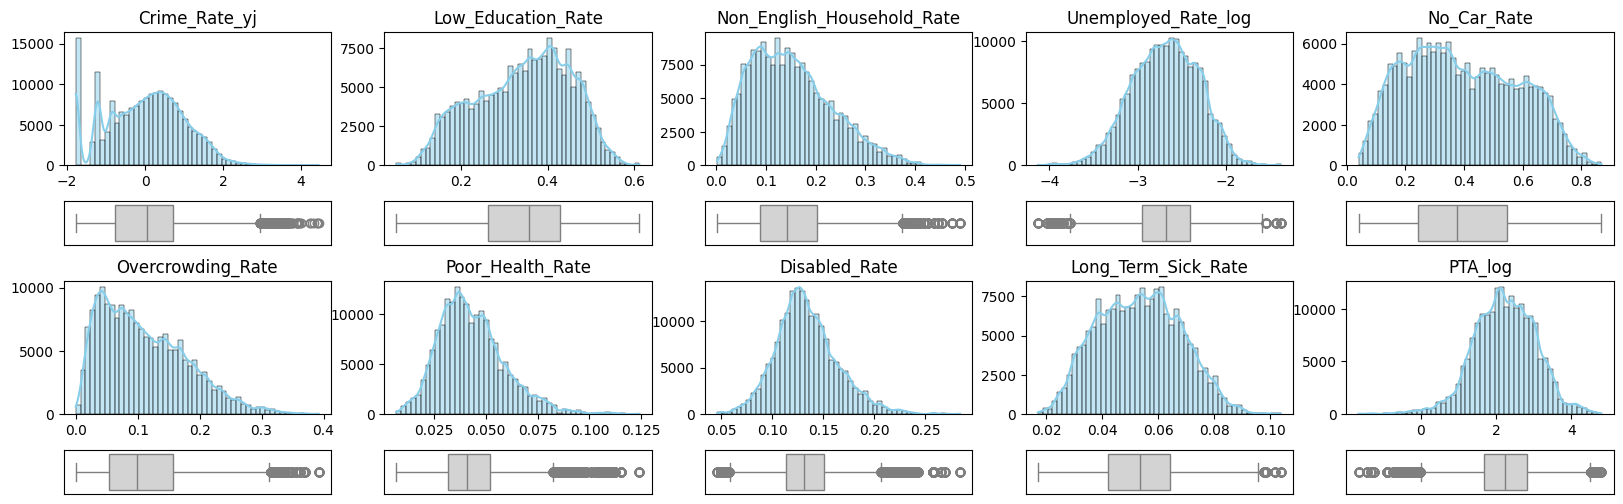

In [24]:
# plot the distribution of all variables
cols_to_plot = [
    "Crime_Rate_yj",
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(4, 5, height_ratios=[3, 1, 3, 1], hspace=0.4)

for i, col in enumerate(cols_to_plot):
    col_index = i % 5
    row_base = (i // 5) * 2  # each group occupies two lines

    # Up: Histogram (height*3)
    ax_hist = fig.add_subplot(gs[row_base, col_index])
    sns.histplot(df_all[col], kde=True, bins=50, color='skyblue', ax=ax_hist)
    ax_hist.set_title(col, fontsize=12)
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("")
    ax_hist.tick_params(axis='x', labelsize=10)
    ax_hist.tick_params(axis='y', labelsize=10)

    # Down: Box plot (height*1)
    ax_box = fig.add_subplot(gs[row_base + 1, col_index])
    sns.boxplot(x=df_all[col], color='lightgray', ax=ax_box)
    ax_box.set_xlabel("")
    ax_box.set_xticks([]) # remobe x, y axis ticks
    ax_box.set_yticks([])

plt.show()

È¶ñÂÖàÔºåÂ¶ÇÂõæ3ÔºåÂ§öÊï∞ÂèòÈáèÈó¥ÂÖ≥Á≥ªÊé•ËøëÁ∫øÊÄßÔºåÂä†‰∏äÂ§ßËá¥ÊàêÊ≠£ÊÄÅÂàÜÂ∏ÉÔºåÊâÄ‰ª•Ê£ÄÊü•‰∏Ä‰∏ãÂèòÈáè‰πãÈó¥ÁöÑpearsonÁõ∏ÂÖ≥ÊÄßÂ¶ÇÂõæ4


KeyboardInterrupt: 

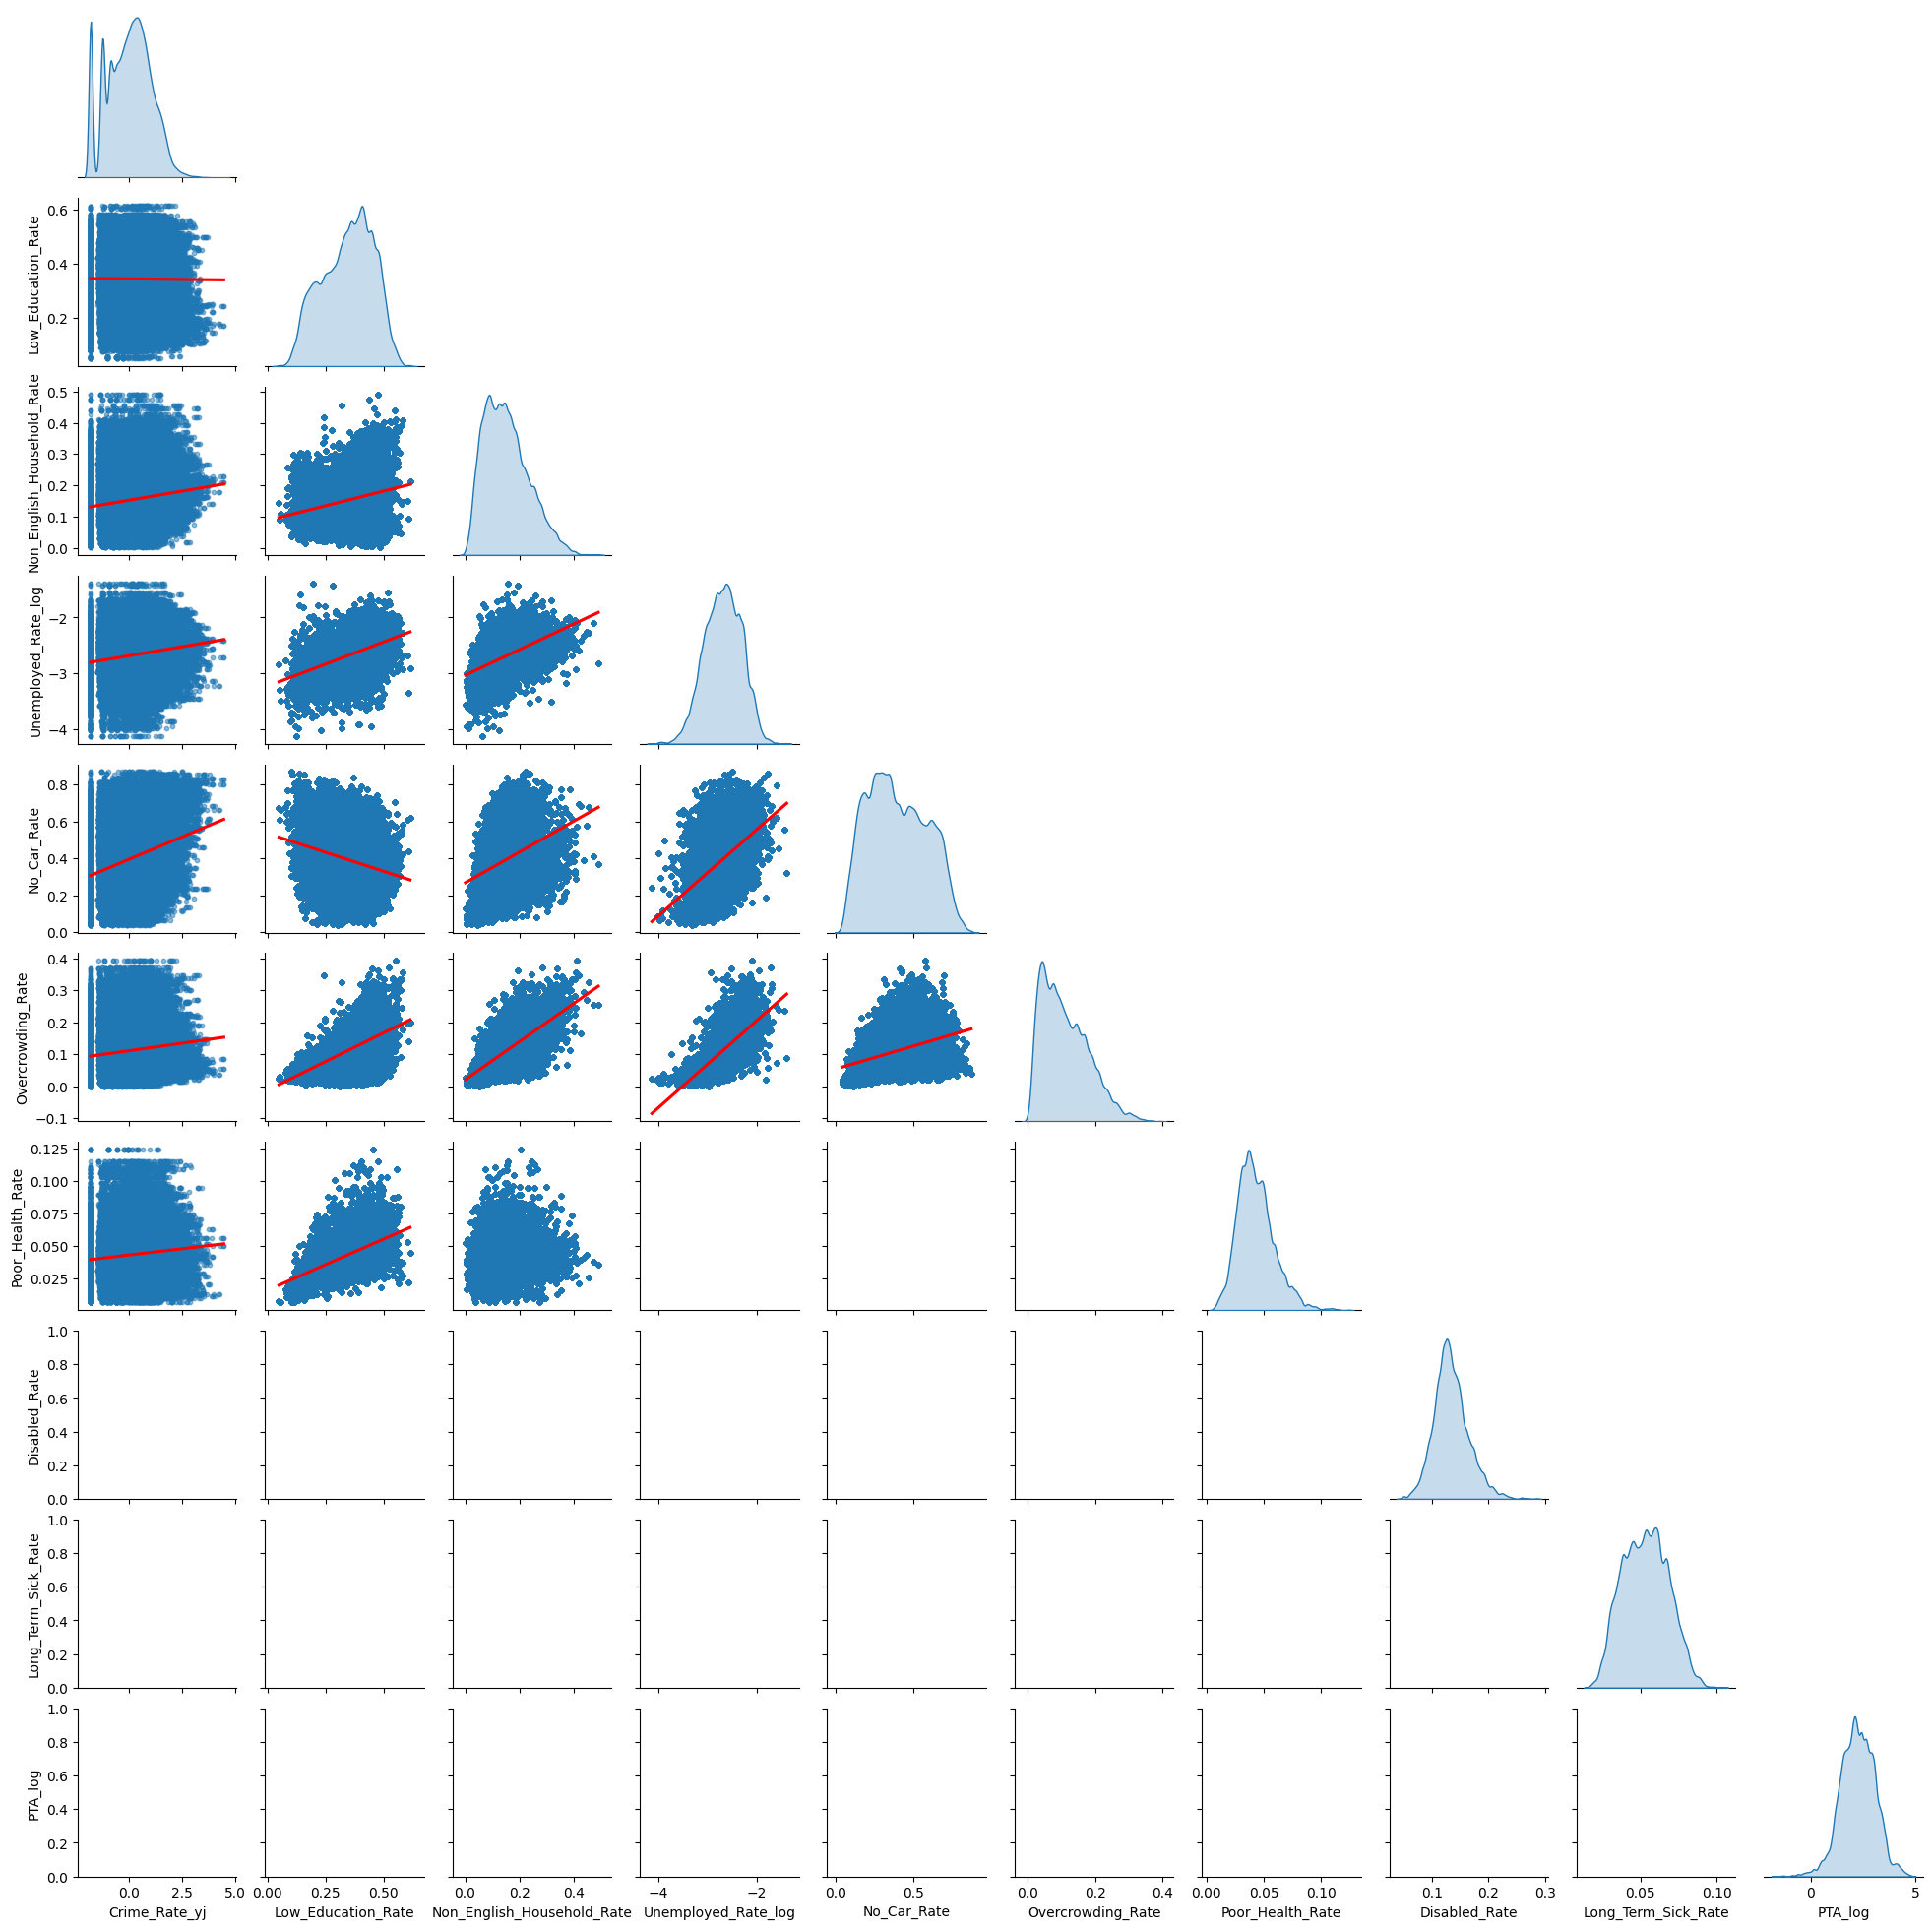

In [25]:
sns.pairplot(
    df_all[cols_to_plot],
    diag_kind="kde", 
    kind="reg", # add reg line on the scatter plot
    corner=True,   # only show the lower triangle
    height=2, 
    plot_kws={"line_kws": {"color": "red"},
              "scatter_kws": {"s": 10, "alpha": 0.5}} 
)

plt.suptitle("Pairwise Relationships of Selected Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

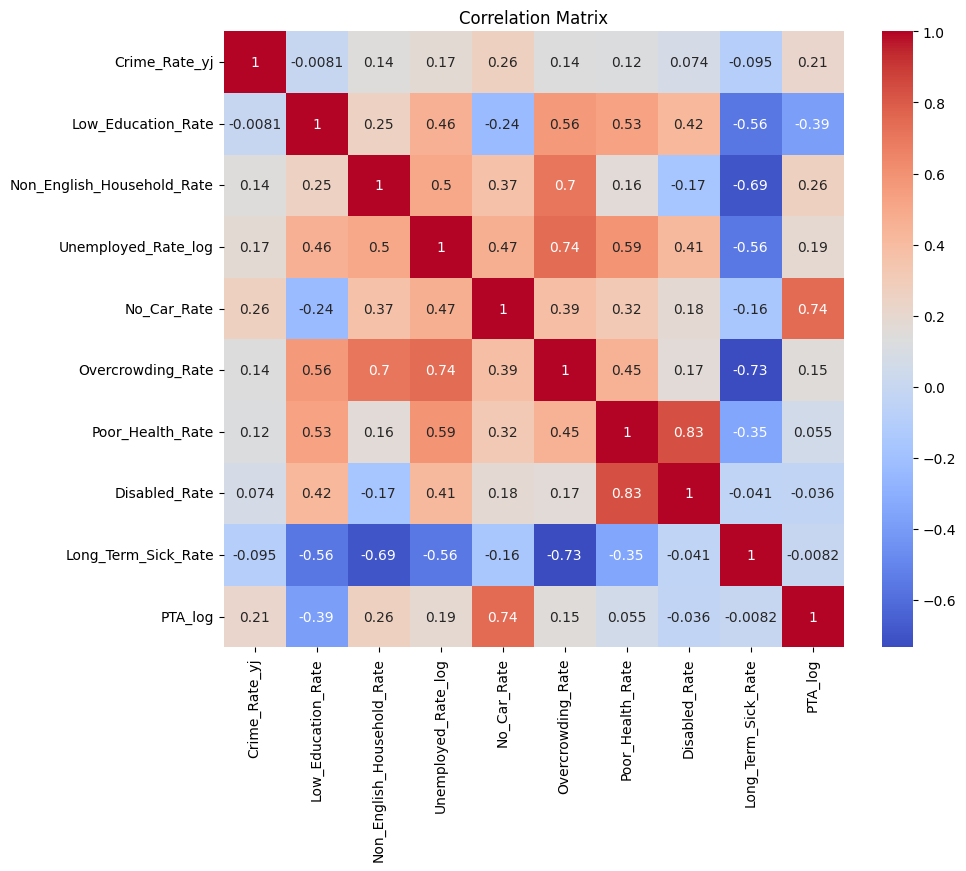

In [27]:
# calculate the correlation matrix
corr_matrix = df_all[cols_to_plot].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

‰ªéÁõ∏ÂÖ≥Áü©ÈòµÂèØ‰ª•ÁúãÂà∞Ôºå‰∏Ä‰∫õÂèòÈáè‰πãÈó¥È´òÂ∫¶Áõ∏ÂÖ≥ÔºàÂ¶ÇÂ§±‰∏öÁéá‰∏éËøáÂ∫¶Êã•Êå§Áéá„ÄÅÂ∑ÆÂÅ•Â∫∑Áéá‰∏éÊÆãÁñæÁéáÁ≠âÔºâ„ÄÇËøôËØ¥ÊòéÂèòÈáè‰πãÈó¥Â≠òÂú®Â§öÈáçÂÖ±Á∫øÊÄßÔºå‰ºöÂØºËá¥Ôºö
ÂõûÂΩíÊ®°Âûã‰∏≠Á≥ªÊï∞‰∏çÁ®≥ÂÆöÔºõÊüê‰∫õÂèòÈáèË¢´ÈáçÂ§çÊîæÂ§ßÔºõÈôç‰ΩéÁªìÊûúËß£ÈáäÊÄß„ÄÇ

Âõ†Ê≠§‰ΩøÁî® PCA ‰∏ªÊàêÂàÜÂàÜÊûê Â∞ÜÂ§ö‰∏™Áõ∏ÂÖ≥ÂèòÈáèÂéãÁº©‰∏∫Â∞ëÊï∞Âá†‰∏™‰∫í‰∏çÁõ∏ÂÖ≥ÁöÑ‰∏ªÊàêÂàÜÔºåÊó¢‰øùÁïô‰∫ÜÂ§ßÈÉ®ÂàÜ‰ø°ÊÅØÔºåÂèàÂáèÂ∞ëÂÜó‰ΩôÂèòÈáèÂØπÊ®°ÂûãÁöÑÂπ≤Êâ∞„ÄÇ


### 4.1. PCA
Â¶ÇÊûúÂéüÂßãÂèòÈáèÈ´òÂ∫¶ÂÅèÊÄÅÔºàÁâπÂà´ÊòØ‰∏•ÈáçÂè≥ÂÅèÔºâÔºå‰ºöËÆ©Â∞ëÊï∞ÊûÅÁ´ØÂÄº‰∏ªÂØºÊñπÂ∑ÆËß£ÈáäÊâÄ‰ª•ÈíàÂØπ‰πãÂâç‰∏•ÈáçÂÅèÊÄÅÁöÑÂèòÈáèÔºàCrime_RateÂíåPublic_Transport_AccessibilityÔºâÈááÁî®ÂÅö‰∫ÜÂØπÊï∞ÂèòÊç¢ÂêéÁöÑÊï∞ÊçÆ„ÄÇ

In [28]:
# select variable columns for dimensionality reduction
cols_for_pca = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all[cols_for_pca])

# Initialize PCA
rand_st_int = 5525 
pca = PCA(random_state=rand_st_int)

X_pca = pca.fit_transform(X_scaled)

print(f"Number of PCs retained: {pca.n_components_}")
print(f"Explained variance ratio of each component: {pca.explained_variance_ratio_}")

# add the principal component results to the original table
for i in range(pca.n_components_):
    df_all[f"PCA_{i+1}"] = X_pca[:, i]

Number of PCs retained: 9
Explained variance ratio of each component: [0.44348997 0.23101478 0.18427584 0.03967997 0.03084459 0.02538293
 0.02185157 0.01269533 0.01076501]


In [29]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=cols_for_pca
)
display(loadings.round(2))

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8  \
Low_Education_Rate          0.31 -0.46 -0.14 -0.11  0.57  0.19  0.00  0.54   
Non_English_Household_Rate  0.34  0.25 -0.39 -0.23 -0.42  0.56 -0.31  0.14   
Unemployed_Rate_log         0.43  0.03  0.07  0.71 -0.02 -0.21 -0.50  0.01   
No_Car_Rate                 0.24  0.50  0.30  0.11 -0.14 -0.07  0.50  0.56   
Overcrowding_Rate           0.44  0.05 -0.21  0.22  0.25  0.23  0.52 -0.54   
Poor_Health_Rate            0.36 -0.21  0.41 -0.30 -0.24  0.06  0.04 -0.27   
Disabled_Rate               0.23 -0.30  0.57 -0.14 -0.13  0.07 -0.10 -0.00   
Long_Term_Sick_Rate        -0.39  0.03  0.37  0.38  0.13  0.73 -0.02  0.00   
PTA_log                     0.10  0.58  0.24 -0.34  0.57 -0.02 -0.35 -0.17   

                             PC9  
Low_Education_Rate         -0.12  
Non_English_Household_Rate  0.10  
Unemployed_Rate_log        -0.10  
No_Car_Rate                -0.04  
Overcrowding_Rate           0.18  
Poor_Health_Rate           -0.66  
Disabled_Rate               0.69  
Long_Term_Sick_Rate        -0.14  
PTA_log                     0.01

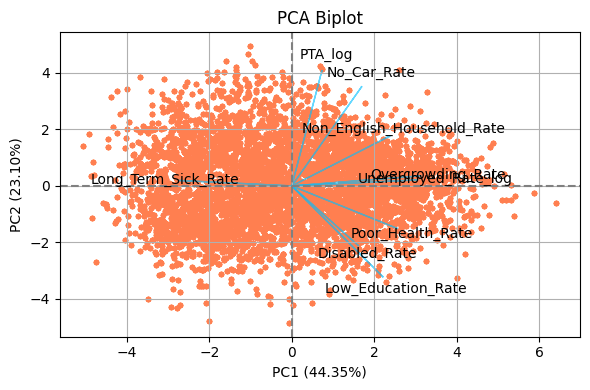

In [30]:
# extract the scores of the first two PCs and draw Biplot
# The figures drawn by 'bioinfokit' are not easy to modify, so use matplotlib to draw.
plt.figure(figsize=(6, 4))
xs = X_pca[:, 0]
ys = X_pca[:, 1]
plt.scatter(xs, ys, alpha=0.2, color="coral", s=8)

for i, var in enumerate(cols_for_pca):
    plt.arrow(0, 0,
              pca.components_[0, i]*7,
              pca.components_[1, i]*7,
              color='deepskyblue', alpha=0.6, head_width=0.02)
    plt.text(pca.components_[0, i]*8,
             pca.components_[1, i]*8,
             var, fontsize=10, ha="center", va="center")

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot")
plt.grid(True)
plt.tight_layout()
plt.show()

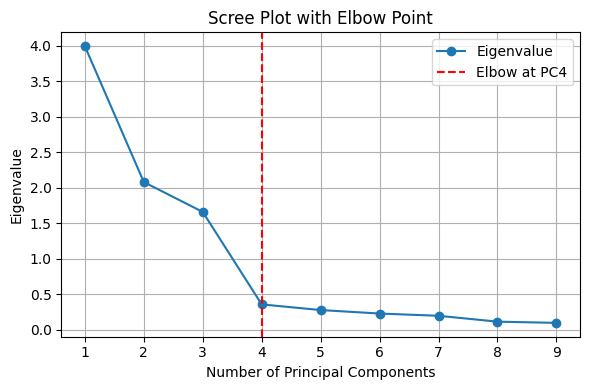

In [31]:
# use Scree plot to locate a point that occurs just before the Scree plot flattens out
eigenvalues = pca.explained_variance_
pcs = list(range(1, len(eigenvalues) + 1))

# use KneeLocator to find the elbow.
knee = KneeLocator(pcs, eigenvalues, curve='convex', direction='decreasing')

plt.figure(figsize=(6, 4))
plt.plot(pcs, eigenvalues, marker='o', label='Eigenvalue')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f'Elbow at PC{knee.knee}')
plt.title("Scree Plot with Elbow Point")
plt.xlabel("Number of Principal Components")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ËÇòÈÉ®ÊòØÁ¢éÁü≥ÂõæÔºàScree PlotÔºâ‰∏≠Êõ≤Á∫ø‰ªéÈô°Â≥≠Âèò‰∏∫Âπ≥ÁºìÁöÑÊãêÁÇπÔºåË°®Á§∫ÁªßÁª≠Â¢ûÂä†‰∏ªÊàêÂàÜÊó∂ÔºåÊñ∞Â¢ûÁöÑ‰ø°ÊÅØË¥°ÁåÆËæπÈôÖÈÄíÂáè„ÄÇÔºàËÇòÈÉ®‰∏çÊòØ‚ÄúÁ¨¨‰∏ÄÊ¨°‰∏ãÈôçÊúÄÂ§ß‚ÄùÔºåËÄåÊòØ‚ÄúÂêéÁª≠ÂºÄÂßãÂπ≥ÁºìÁöÑÊãêÁÇπ‚ÄùÔºâPC1 ‚Üí PC2 ÁöÑ‰∏ãÈôçËôΩÁÑ∂Â§ßÔºå‰ΩÜ‰ªé PC2 Âà∞ PC3„ÄÅPC3 Âà∞ PC4 ÁöÑ‰∏ãÈôç‰ªçÁÑ∂ÊòæËëóÔºõÊç¢Âè•ËØùËØ¥ÔºåPC2 ‰πãÂêé‰ªçÁÑ∂Êúâ‚ÄúËæÉÂ§ßÁöÑ‰ø°ÊÅØÈáè‚Äù„ÄÇÊâÄ‰ª• PC4 ÊòØËøô‰∏™‚Äú‰ªéÈô°Âà∞Áºì‚ÄùÁöÑ‰∏¥ÁïåÁÇπÔºåÂ∞ΩÁÆ°Âè™Â§öËß£Èáä‰∫Ü0.03959046Ôºå‰ΩÜÊòØËøòÊòØÂèñÂà∞4ÔºåËÄå‰∏îKneeLocatorÊåáÁ§∫ÁöÑ‰πüÊòØ4

In [32]:
variance_explained = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]
print(f"Proportion of variance explained by PC1 to PC4: {variance_explained:.2%}")

Proportion of variance explained by PC1 to PC4: 89.85%


‰∏∫‰∫ÜËß£ÂÜ≥ÂèòÈáè‰πãÈó¥Â≠òÂú®ÁöÑÂ§öÈáçÂÖ±Á∫øÊÄßÈóÆÈ¢òÔºåÂπ∂ÊèêÂèñËÉåÂêéÊΩúÂú®ÁöÑÁ§æ‰ºöÁªèÊµéÁªìÊûÑÁâπÂæÅÔºåÊàë‰ª¨ÂØπ 9 ‰∏™Ê†áÂáÜÂåñÂêéÁöÑÂèòÈáèËøõË°å‰∫Ü‰∏ªÊàêÂàÜÂàÜÊûêÔºàPCAÔºâ„ÄÇËøô‰∫õÂèòÈáèÂåÖÊã¨ÊïôËÇ≤„ÄÅËØ≠Ë®Ä„ÄÅÂ§±‰∏ö„ÄÅ‰∫§ÈÄö„ÄÅ‰ΩèÊàø„ÄÅÂÅ•Â∫∑Á≠âÊñπÈù¢ÁöÑÊØîÁéáÂûãÊåáÊ†á„ÄÇ

‰∏ªÊàêÂàÜÂàÜÊûêÁªìÊûúÊòæÁ§∫Ôºö
Ê†πÊçÆ Scree Plot ÁöÑËÇòÈÉ®Ê≥ïÂàôÔºåÊúÄ‰ºò‰øùÁïôÁöÑ‰∏ªÊàêÂàÜ‰∏™Êï∞‰∏∫Ââç 4 ‰∏™‰∏ªÊàêÂàÜÁ¥ØËÆ°Ëß£Èáä‰∫Ü 89.86% ÁöÑÊÄªÊñπÂ∑ÆÔºåÂÖ∂‰∏≠ PC1 Âíå PC2 ÂàÜÂà´Ëß£Èáä‰∫Ü 44.5% Âíå 23.1%ÔºåÂÖ∑Â§áËæÉÂº∫ÁöÑ‰ª£Ë°®ÊÄß„ÄÇ
- PC1ÔºàSocioeconomic_DisadvantageÔºâÔºöËøô‰∏™Áª¥Â∫¶Âº∫ÁÉàÂÖ≥ËÅî‰∫é‚ÄúÁ§æ‰ºöÁªèÊµéÂº±ÂäøÁæ§‰ΩìËÅöÈõÜÂå∫Âüü‚Äù„ÄÇ‰ΩéÊïôËÇ≤„ÄÅÂ§±‰∏ö„ÄÅÈ´òÂØÜÂ∫¶Â±Ö‰Ωè„ÄÅÂÅ•Â∫∑Áä∂ÂÜµÂ∑Æ„ÄÅ‰∫§ÈÄöÊù°‰ª∂Â∑ÆÁöÑÂú∞Âå∫ÔºåÂæóÂàÜÊõ¥È´ò„ÄÇ
- PC2ÔºàUrban_ConnectivityÔºâÔºöËøô‰∏™Áª¥Â∫¶‰∏ªË¶ÅÂèçÊò†‚Äú‰∫§ÈÄöÂèØËææÊÄß‚Äù„ÄÇÂæóÂàÜÈ´òÁöÑÂú∞Âå∫‰∫§ÈÄöÊù°‰ª∂Â•ΩÔºåÊïôËÇ≤Ê∞¥Âπ≥Êõ¥È´ò„ÄÅËΩ¶ËæÜÊã•ÊúâÁéá‰πüÊõ¥È´ò„ÄÇ
- PC3ÔºàLanguage_IsolationÔºâÔºöNon_English_Household_Rate ‰∏∫‰∏ªË¶ÅÊ≠£ÂêëË¥°ÁåÆÔºåÂÖ∂‰ΩôÂèòÈáèÊùÉÈáçÂ∞è„ÄÇÈ´òÂàÜÊÑèÂë≥ÁùÄÈùûËã±ËØ≠ÂÆ∂Â∫≠ÈõÜ‰∏≠ÔºåÂèØËÉΩÊöóÁ§∫ËæÉÂº∫ÁöÑÊóèÁæ§ËÅöÂ±ÖÁâπÂæÅ„ÄÇ
- PC4ÔºàÂÅ•Â∫∑Áä∂ÂÜµÔºâÔºö‰∏ªË¶ÅÁî± Poor_Health_Rate Âíå Long_Term_Sick_Rate Ë¥°ÁåÆ„ÄÇÈ´òÂàÜÊÑèÂë≥ÁùÄÂÅ•Â∫∑Áä∂ÂÜµÂ∑ÆÔºåÂèØËÉΩ‰∏éÁ§æ‰ºöÁªèÊµéÂä£ÂäøÁõ∏ÂÖ≥„ÄÇ

ÈÄöËøá PCA ÈôçÁª¥ÔºåÊàë‰ª¨Âú®‰øùÁïô‰∏ªË¶Å‰ø°ÊÅØÁöÑÂü∫Á°Ä‰∏äÊúâÊïàÈôç‰Ωé‰∫ÜÂèòÈáèÁª¥Â∫¶Ôºå‰∏∫ÂêéÁª≠ÁöÑËÅöÁ±ªÂàÜÊûêÂíåÂõûÂΩíÂª∫Ê®°Êèê‰æõ‰∫ÜÊõ¥Âä†Á®≥ÂÅ•ÁöÑËæìÂÖ•ÂèòÈáè„ÄÇ

### 4.2. ÂàùÊ≠•Á∫øÊÄßÂõûÂΩí

#### Ê£ÄÊü•ÂÅáËÆæ

> A. Linearity
> 
> B. Homoscedasticity
> 
> C. Normality of residuals
> 
> D. Independence of errors
> 
> E. Multicollinearity (PCAÂ∑≤ÁªèÊ∂àÈô§)


<Figure size 600x400 with 0 Axes>

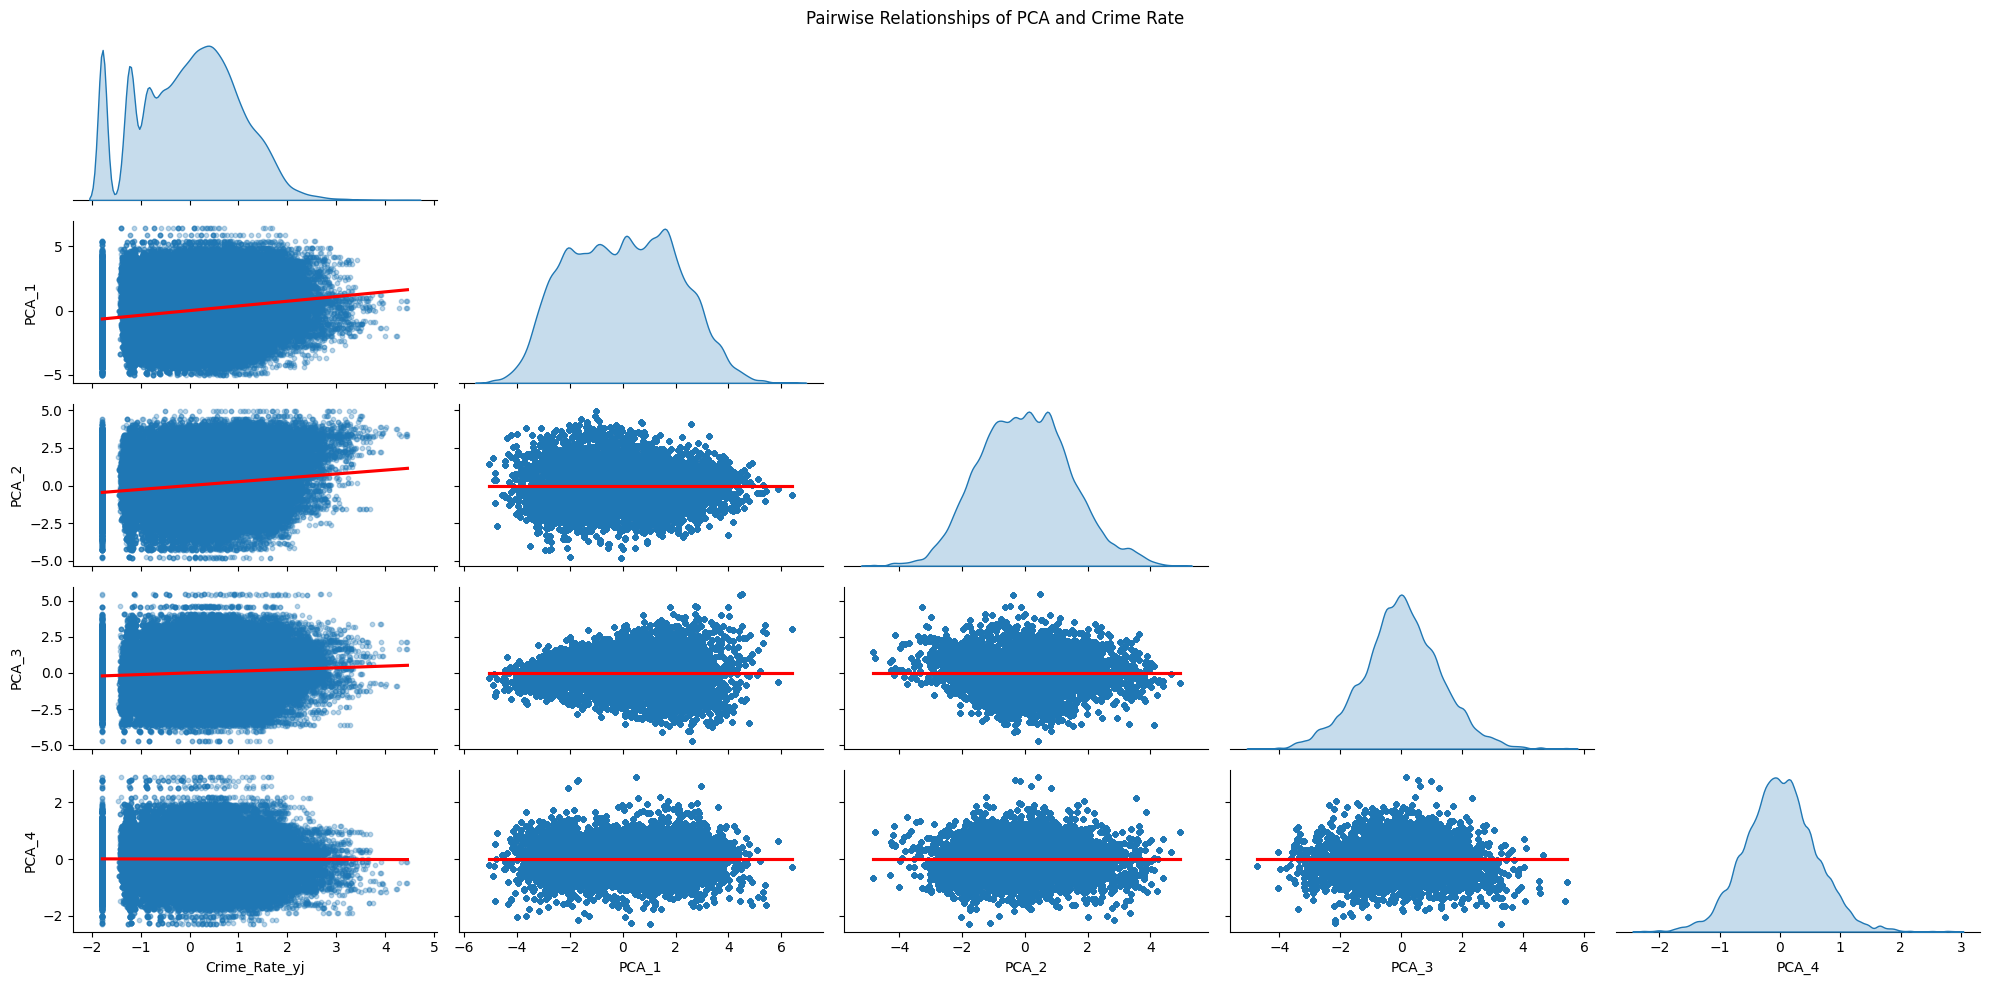

In [33]:
# A. Linearity
plt.figure(figsize=(6, 4))

sns.pairplot(
    df_all[["Crime_Rate_yj", "PCA_1", "PCA_2", "PCA_3", "PCA_4"]],
    diag_kind="kde",
    kind="reg",
    corner=True,
    height=2, 
    aspect=2, #the picture is compressed here for typesetting
    plot_kws={"line_kws": {"color": "red"}, 
              "scatter_kws": {"alpha": 0.3, "s": 10}}
)

plt.suptitle("Pairwise Relationships of PCA and Crime Rate", fontsize=12)
plt.tight_layout()
plt.show()


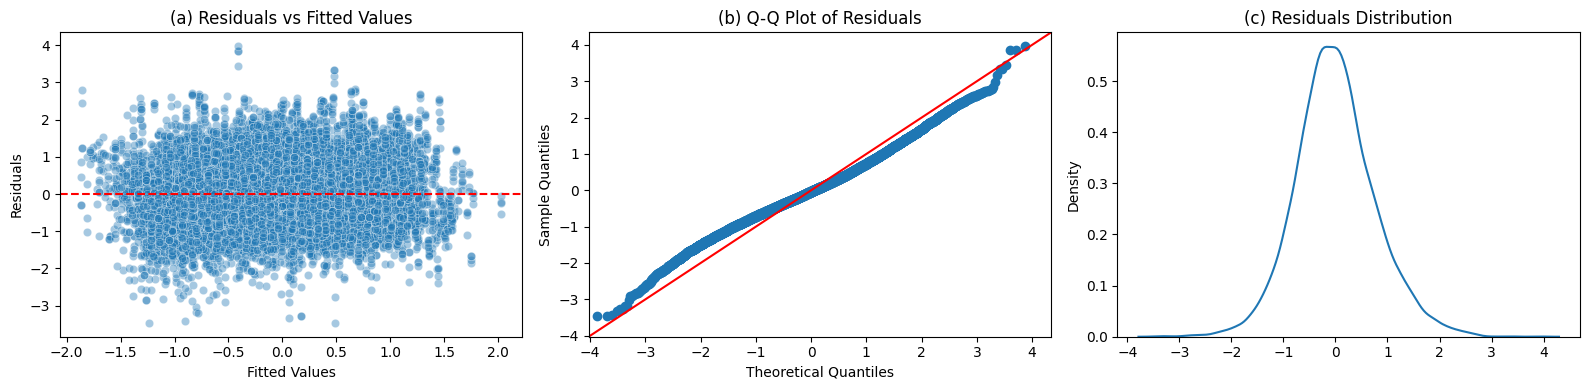

Durbin-Watson statistic: 0.6487436928814841


In [87]:
# fit the model
X = df_all[["PCA_1", "PCA_2", "PCA_3", "PCA_4"]]
X = sm.add_constant(X)
y = df_all["Crime_Rate_yj"]

model = sm.OLS(y, X).fit()


fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# B. Homoscedasticity
# leftÔºöResiduals vs Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.4, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Residuals")
axs[0].set_title("(a) Residuals vs Fitted Values")

# C. Normality of residuals
# middleÔºöQ-Q plot
sm.qqplot(residuals, line='45', ax=axs[1])
axs[1].set_title("(b) Q-Q Plot of Residuals")

# rightÔºöKDE plot
sns.kdeplot(residuals, ax=axs[2])
axs[2].set_title("(c) Residuals Distribution")

plt.tight_layout()
plt.show()


# D. Independence of errors
dw_stat = durbin_watson(model.resid) 
print("Durbin-Watson statistic:", dw_stat)


**A. Linearity**:‰ΩøÁî® sns.pairplot() Êü•ÁúãËá™ÂèòÈáè‰∏éÂõ†ÂèòÈáè‰πãÈó¥ÁöÑÊï£ÁÇπÂàÜÂ∏É‰∏éÊãüÂêàÁ∫ø„ÄÇÂõænÁªìÊûúÊòæÁ§∫Â§ßÂ§öÊï∞‰∏ªÊàêÂàÜ‰∏éÁäØÁΩ™ÁéáÂëàÁé∞Âá∫Â§ßËá¥Á∫øÊÄßË∂ãÂäø, Âü∫Êú¨Êª°Ë∂≥.
**B. Homoscedasticity**:Âõæn-a,Residuals vs Fitted Plot Â±ïÁ§∫‰∏∫‰∫ëÁä∂ÂàÜÂ∏ÉÔºåÊú™ÂëàÁé∞ÊºèÊñóÁä∂ÊàñÊâ©Âº†Ë∂ãÂäø„ÄÇÂü∫Êú¨Êª°Ë∂≥.
C. Normality of residualsÔºö‰ΩøÁî®QQ n-b ÂíåKDE n-c Ê£ÄÊü•ÊÆãÂ∑ÆÁöÑÊ≠£ÊÄÅÊÄß„ÄÇÊÆãÂ∑ÆÊé•ËøëÊ≠£ÊÄÅÔºå‰ΩÜÂú®Â∞æÈÉ®Áï•ÊúâÂÅèÁ¶ª„ÄÇÂü∫Êú¨Êª°Ë∂≥.
D. Independence of errorsÔºöÊü•Áúã Durbin-Watson ÁöÑÁªìÊûú„ÄÇÊòæËëó‰Ωé‰∫é 2,ÂèØËÉΩÂ≠òÂú® ÊÆãÂ∑Æ‰πãÈó¥ÁöÑÊ≠£Ëá™Áõ∏ÂÖ≥.Â∑≤ÁªèÂØπÂèòÈáèÂÅö‰∫ÜÂ§ßÈáèÂâçÂ§ÑÁêÜÔºåÂåÖÊã¨ PCA ÂíåÂèòÊç¢ ‚Äî‚Äî ÊâÄ‰ª•ÁªìÊûÑÊÄßËá™Áõ∏ÂÖ≥ÂæàÂèØËÉΩÊù•Ëá™Êï∞ÊçÆÊú¨Ë∫´ÁöÑÊó∂Èó¥ÊàñÁ©∫Èó¥ÁªìÊûÑÔºàÊØîÂ¶Ç LSOA Âõ∫ÂÆöÁâπÂæÅÊàñÂπ¥‰ªΩÂõ†Á¥†Ôºâ„ÄÇËÄÉËôëÂºïÂÖ•Âõ∫ÂÆöÊïàÂ∫îÔºàFixed EffectsÔºâ‰ΩøÁî® Panel Regression
E. Multicollinearity: PCAÂ∑≤ÁªèÊ∂àÈô§

In [77]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Crime_Rate_yj   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     3181.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:29:37   Log-Likelihood:                -21560.
No. Observations:               18612   AIC:                         4.313e+04
Df Residuals:                   18607   BIC:                         4.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.249e-15      0.006   3.98e-13      1.0

‰ªéÂõûÂΩíÁªìÊûúÂèØ‰ª•ÁúãÂá∫R-squared = 0.406ÔºåÊ®°ÂûãÂèØ‰ª•Ëß£ÈáäÂ§ßÁ∫¶ 40.6% ÁöÑÁäØÁΩ™ÁéáÂèòÂºÇ„ÄÇ‰ΩÜÊòØËß£ÈáäÊÄßÊ≤°ÊúâÈÇ£‰πàÂ•ΩÔºå

### 4.3. Clustering
Âú®ÂºïÂÖ•Âõ∫ÂÆöÊïàÂ∫î‰πãÂâçÈÄöËøáclusteringÁúã‰∏Ä‰∏ãÊòØÂê¶Âú®ÊØèÂπ¥„ÄÅÁöÑ‰∏çÂêåÂå∫ÂüüÊúâÂ∑ÆÂºÇ„ÄÇÂõ†‰∏∫crimerate numericÔºåÊâÄ‰ª•Êé•‰∏ãÊù•‰ΩøÁî® K-means ËÅöÁ±ªÁÆóÊ≥ïÂØπÊï∞ÊçÆËøõË°åËÅöÁ±ª„ÄÇ

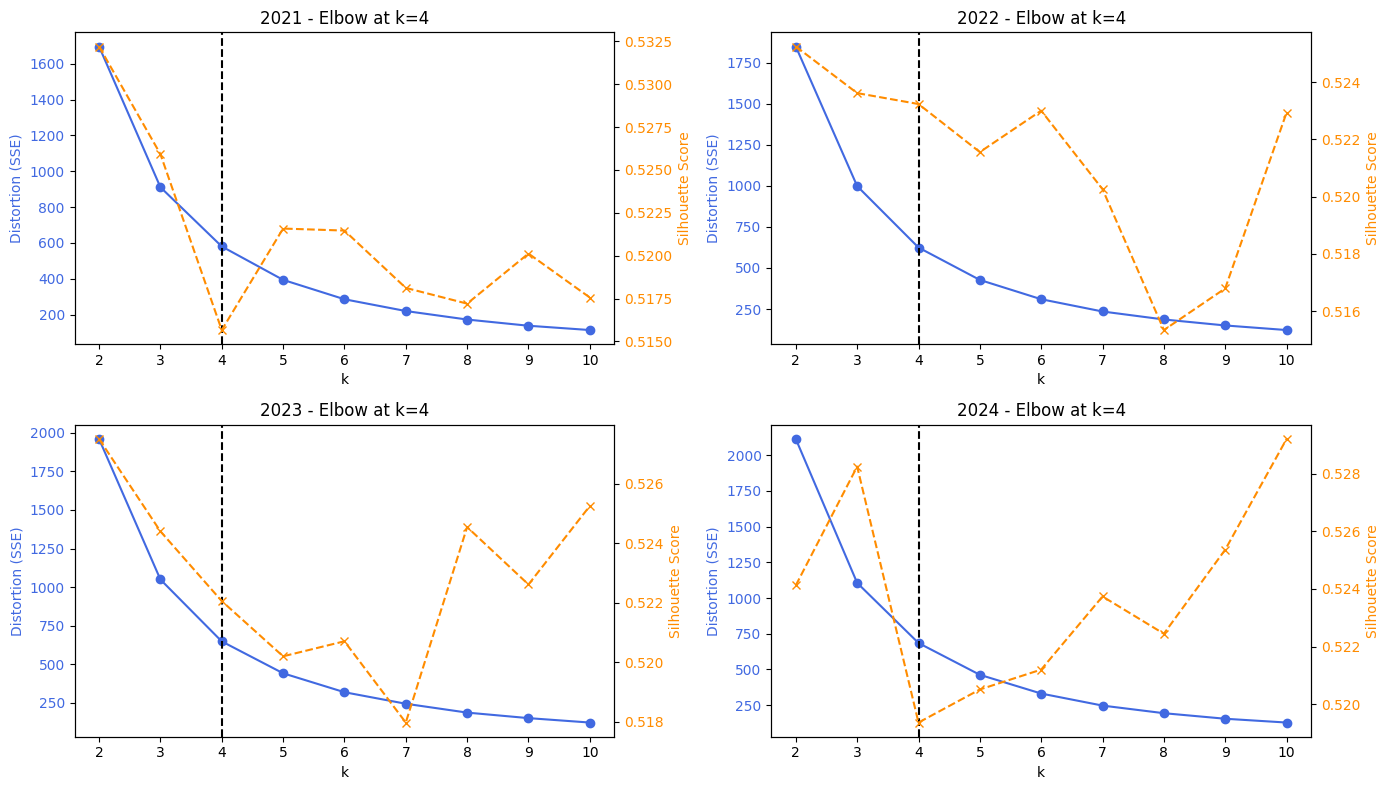

In [117]:
years = ['2021', '2022', '2023', '2024']
k_range = range(2, 11)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i, year in enumerate(years):
    df_year = df_all[df_all['Year'] == year]
    X = df_year[['Crime_Rate_yj']]

    sse = []
    silhouette = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=5525, n_init=10)
        labels = kmeans.fit_predict(X)
        sse.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, labels))

    # fine elbow point
    kl = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
    elbow_k = kl.elbow
    
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax2 = ax.twinx()
    
    # elbow plot
    ax.plot(k_range, sse, marker='o', color='royalblue')
    ax.axvline(elbow_k, linestyle='--', color='black')
    ax.set_title(f"{year} - Elbow at k={elbow_k}")
    ax.set_xlabel("k")
    ax.set_ylabel("Distortion (SSE)", color='royalblue')
    ax.tick_params(axis='y', labelcolor='royalblue')

    # silhouette plot
    ax2.plot(k_range, silhouette, marker='x', color='darkorange', linestyle='--')
    ax2.set_ylabel("Silhouette Score", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

plt.tight_layout()
plt.show()

ËôΩÁÑ∂ËÇòÈÉ®Ê≥ïÂú®Âõõ‰∏™Âπ¥‰ªΩÂùáÊé®Ëçê‰ΩøÁî® k=4Ôºå‰ΩÜ Silhouette ÂæóÂàÜÂú® 2021 Âíå 2024 Ë°®Áé∞ËæÉÂ∑ÆÔºåËØ¥ÊòéËøô‰∫õÂπ¥‰ªΩÁöÑÁ±ªÂÜÖ‰∏ÄËá¥ÊÄßÊàñÁ±ªÈó¥ÂàÜÁ¶ªÂ∫¶‰∏çÂ§üÁêÜÊÉ≥ÔºåÊöóÁ§∫ÂêÑÊó∂Èó¥ÁÇπÁöÑËÅöÁ±ªÁªìÊûÑÂ≠òÂú®Â∑ÆÂºÇ„ÄÇËøôË°®ÊòéÁäØÁΩ™ÁéáÁöÑÁ©∫Èó¥ÂàÜÂ∏ÉÂú®‰∏çÂêåÂπ¥‰ªΩÂπ∂‰∏çÂÆåÂÖ®‰∏ÄËá¥ÔºåÂ≠òÂú®Êó∂ÂèòÁöÑÂú∞ÁêÜÁªìÊûÑËß£Èáä‰∫Ü‰∏∫Á§æ‰πà‰ªÖ‰ΩøÁî®Ê®™Êà™Èù¢ÊñπÊ≥ïÂèØËÉΩÊó†Ê≥ïÊçïÊçâÊó∂Èó¥ÂèòÂåñÂ∏¶Êù•ÁöÑÊ®°ÂºèÊºîÂèò„ÄÇ ‰ΩÜÊòØ‰∏∫‰∫ÜÊñπ‰æøÂØπÊØîÂú®clusteringÁªìÊûúÁöÑÂèØËßÜÂåñ‰∏≠‰∏≠ËøòÊòØ‰ΩøÁî®‰∫Ük=4

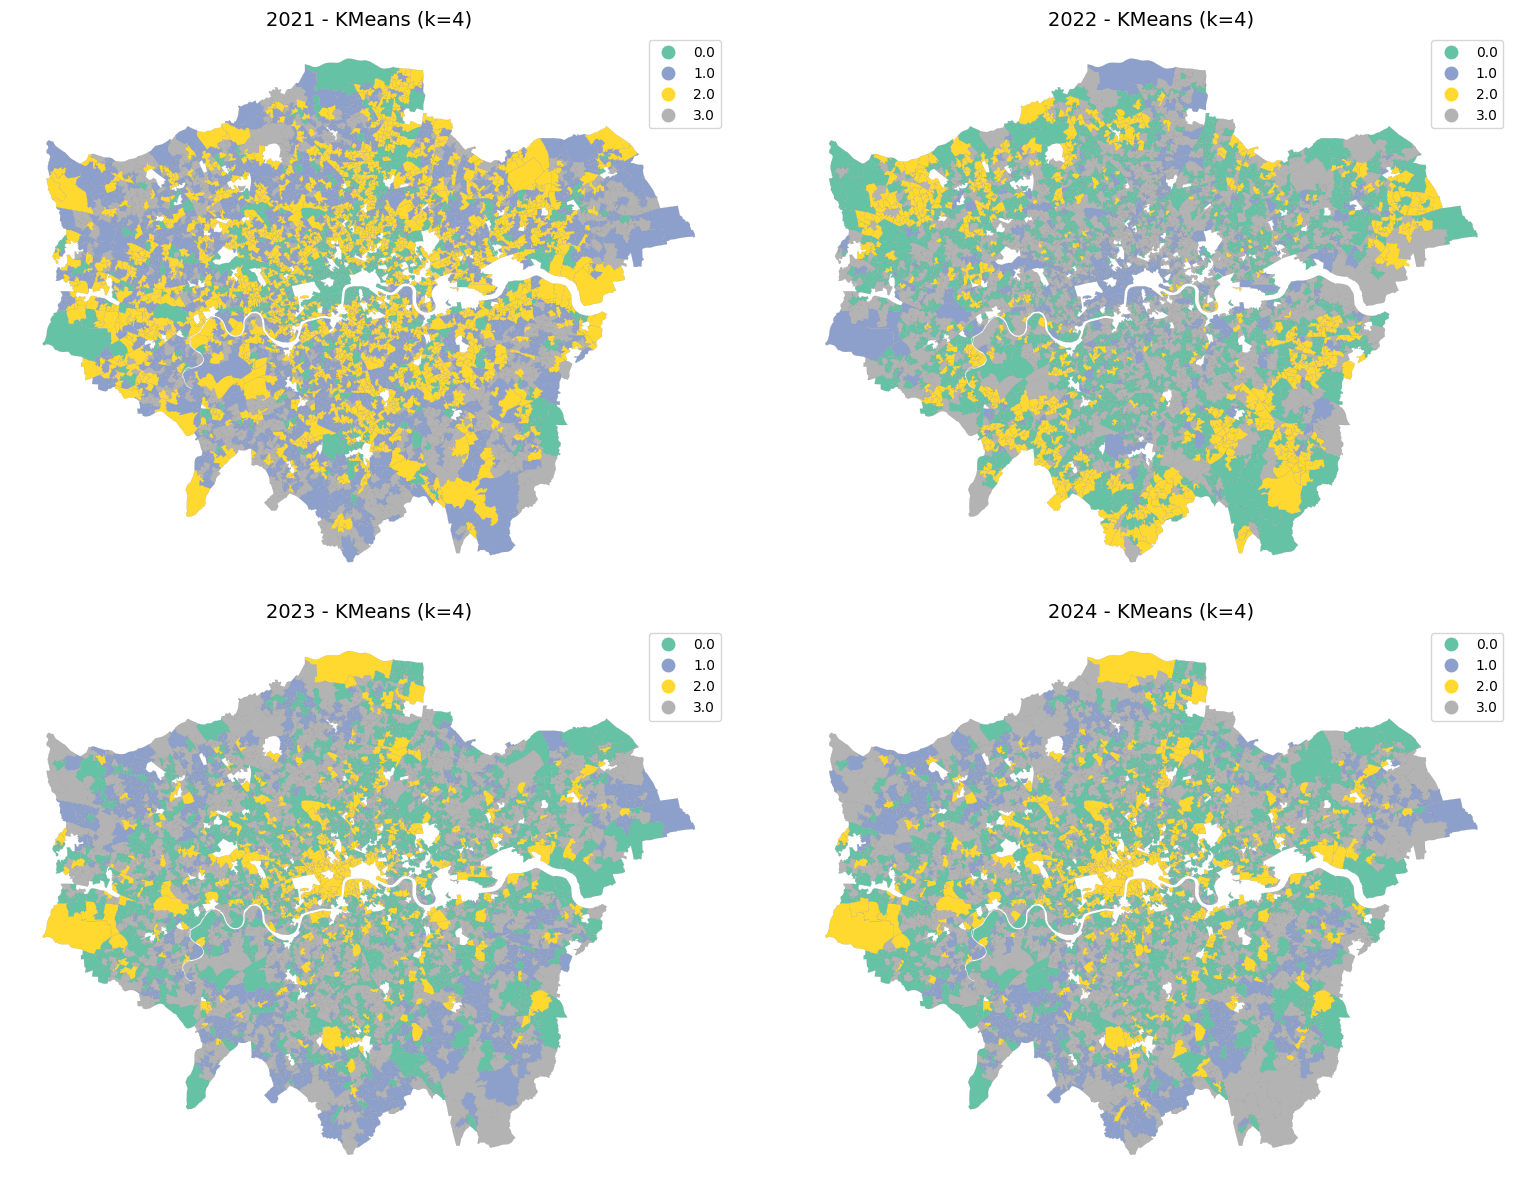

In [122]:
# ‰øùËØÅ geodataframe Êúâ LSOA_Code Â≠óÊÆµ
gdf_c_plot = gdf.copy()
gdf_c_plot = gdf_c_plot.rename(columns={"LSOA11CD": "LSOA_Code"})

# ËÆæÁΩÆÂπ¥‰ªΩÂíåÂ≠êÂõæ
years = ["2021", "2022", "2023", "2024"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, year in enumerate(years):
    df_year = df_all[df_all["Year"] == year].copy()
    X = df_year[["Crime_Rate_yj"]]
    lsoa_codes = df_year["LSOA_Code"].values

    # ËÅöÁ±ª
    kmeans = KMeans(n_clusters=4, random_state=5525, n_init=10)
    labels = kmeans.fit_predict(X)

    # ÂêàÂπ∂Á©∫Èó¥Êï∞ÊçÆ
    df_clustered = pd.DataFrame({"LSOA_Code": lsoa_codes, "cluster": labels})
    gdf_plot = gdf_c_plot.merge(df_clustered, on="LSOA_Code", how="left")

    # ÁîªÂõæ
    row, col = divmod(i, 2)
    ax = axes[row, col]
    gdf_plot.plot(
        column="cluster",
        categorical=True,
        legend=True,
        cmap="Set2",
        linewidth=0.1,
        edgecolor="grey",
        ax=ax
    )
    ax.set_title(f"{year} - KMeans (k=4)", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

‰ªéËÅöÁ±ªÂú∞ÂõæÁªìÊûúÂèØ‰ª•ÁúãÂá∫ÔºåLSOA ÁöÑÁ©∫Èó¥ÂàÜÂ∏ÉÊ†ºÂ±ÄÂëàÁé∞Âá∫‰∏ÄÂÆöÁöÑÂèòÂåñË∂ãÂäøÂ∞§ÂÖ∂ÊòØ‰∏≠ÈÉ®ÂíåÂ§ñÂõ¥ÁöÑËÅöÁ±ªÈ¢úËâ≤ÂèëÁîü‰∫Ü‰∏Ä‰∫õËΩ¨Êç¢ÔºåÊèêÁ§∫Êüê‰∫õÂå∫ÂüüÁöÑÁäØÁΩ™ÁéáËÅöÁ±ªÁ±ªÂà´ÂèØËÉΩÂú®‰∏çÂêåÂπ¥‰ªΩÂèëÁîü‰∫ÜÂèòÂåñ„ÄÇËøôÊ≠£ÊòØ‰ΩøÁî® Âõ∫ÂÆöÊïàÂ∫î Panel Regression ÁöÑÂä®Âõ†„ÄÇ

In [46]:
cols_to = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

# Á°Æ‰øù Year ÊòØÊï¥Êï∞ÔºàÊàñ‰πüÂèØ‰ª• pd.to_datetimeÔºâ
df_panel = df_all.copy()
df_panel["Year"] = df_panel["Year"].astype(int)

df_panel["Panel_ID"] = df_panel["LSOA_Code"] + "_" + df_panel["Major_Category"]

# ËÆæÁΩÆÈù¢ÊùøÁ¥¢ÂºïÔºàÊ≥®ÊÑèÈ°∫Â∫èÔºö‰∏™‰ΩìÂú®ÂâçÔºåÊó∂Èó¥Âú®ÂêéÔºâ
# ËÆæÁΩÆ‰∏∫ 2 Â±Ç MultiIndexÔºöPanel_ID √ó Year
df_panel = df_panel.set_index(["Panel_ID", "Year"])


from linearmodels.panel import PanelOLS

# Ëá™ÂèòÈáèÔºà‰∏çË¶ÅÂê´ÊúâÊó∂Èó¥‰∏çÂèòÂèàÂíåÂõ∫ÂÆöÊïàÂ∫îÂÜ≤Á™ÅÁöÑÂèòÈáèÔºâ
exog_vars = cols_to
X = df_panel[exog_vars]
y = df_panel["Crime_Rate_yj"]

# Ê®°ÂûãËÆæÂÆöÔºöÂÆû‰ΩìÂõ∫ÂÆöÊïàÂ∫îÔºàLSOA+CrimeType ÁªÑÂêàÔºâÔºå‰∏çÂä†Êó∂Èó¥ÊïàÂ∫î
model = PanelOLS(y, X, entity_effects=True)
results = model.fit()

print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Crime_Rate_yj   R-squared:                        0.0000
Estimator:                   PanelOLS   R-squared (Between):             -0.1941
No. Observations:              183572   R-squared (Within):               0.0000
Date:                Sun, Apr 20 2025   R-squared (Overall):             -0.1620
Time:                        00:26:54   Log-likelihood                -5.317e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0000
Entities:                       46448   P-value                           1.0000
Avg Obs:                       3.9522   Distribution:                F(9,137115)
Min Obs:                       2.0000                                           
Max Obs:                       4.0000   F-statistic (robust):          3.368e-30
                            

### 4.4. Panel Regression
Âõ†‰∏∫ panel regression ÁöÑÊ†∏ÂøÉ‰ª∑ÂÄº ÊòØÔºöÂú®ÊéßÂà∂ÊØè‰∏™‰∏™‰ΩìÔºàÂ¶ÇÊØè‰∏™ LSOAÔºâÁöÑ‰∏çÂèòÁâπÂæÅÁöÑÂâçÊèê‰∏ãÔºåÂàÜÊûê ÈöèÊó∂Èó¥ÂèòÂåñÁöÑÂèòÈáè Â¶Ç‰ΩïÂΩ±ÂìçÈöèÊó∂Èó¥ÂèòÂåñÁöÑÁªìÊûú„ÄÇ
Âõ†ÂèòÈáè Crime_Rate_yjÔºöÊòØÊØèÂπ¥ÂèòÂåñÁöÑ„ÄÇ
	‚Ä¢	ÊâÄÊúâËá™ÂèòÈáèÔºàPCA_1~4ÔºâÔºöÂü∫‰∫é 2021Âπ¥CensusÊï∞ÊçÆÔºåÂØπÊØè‰∏™ LSOA ÈÉΩÊòØÂõ∫ÂÆö‰∏çÂèòÁöÑ„ÄÇ
	‚Ä¢	ÊâÄ‰ª•Âç≥‰ΩøÊúâÂõõÂπ¥ÁöÑÈù¢ÊùøÂΩ¢ÂºèÔºåËß£ÈáäÂèòÈáèÂú® panel ÁªìÊûÑ‰∏≠ÊòØÊó∂Èó¥‰∏çÂèòÁöÑ„ÄÇ

Âú®Èù¢ÊùøÊ®°Âûã‰∏≠ÔºåÂ¶ÇÊûú‰Ω†Âä†‰∫Ü LSOA Âõ∫ÂÆöÊïàÂ∫îÔºàentity_effects=TrueÔºâÔºåËÄåËá™ÂèòÈáèÂèà‰∏çÈöèÊó∂Èó¥ÂèòÂåñÔºåÈÇ£‰πàËøô‰∫õÂèòÈáèÂ∞±‰ºöË¢´ÂÆåÂÖ®Âê∏Êî∂ÔºàabsorbedÔºâÔºåÂõ†‰∏∫Ê®°ÂûãÊ≤°Ê≥ïÂå∫ÂàÜÂèòÈáèÂíåÂçï‰ΩçËá™Ë∫´ÁöÑÂõ∫ÂÆöÊïàÂ∫î„ÄÇ



## 5. Results and discussion

[[ go back to the top ]](#Table-of-contents)

## 6. Conclusion

[[ go back to the top ]](#Table-of-contents)

## 7.References

[[ go back to the top ]](#Table-of-contents)

In [26]:
end_time = time.time()
total_time = end_time - start_time

mins, secs = divmod(total_time, 60)
print(f"üïí Notebook running time: {int(mins)} h {int(mins)} m {secs:.2f} s")

üïí Notebook running time: 0 h 0 m 41.28 s
